### Introduction
#### About 80% of Singaporeans stay in a HDB flat. Since the first introduction of the cooling measure in 2010, HDB resale flat price has been quite stabilize. Let see if we can forecast how the HDB resale price will be moving just by visualizing the data collected from past years.

### Objective
#### - Compare the variables in the data and see if it  affect the resale pricing.
#### - How location affect the resale pricing?
#### - Which town has the most transaction and why?
#### - What is the market trend like for the past years?
#### - Finally what do we expect the market trend to be like for 2021?

### CHALLENGE:

#### - To convert the values in column ‘remaining_lease’ from string to float so that we can do some calculation.
#### - To get the geolocation of each flat transacted and MRT station using New OneMap API Docs.
#### - To get the estimated travelling time from each town to Shenton Way (Raffles Place MRT station).

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
%matplotlib inline

### Read and do some basic prepareation of  the data

In [316]:
df = pd.read_csv('Resale Flat Price.csv', index_col='month',  # convert 'month' to timestamp and set as index
                 parse_dates=True)                            
df.index.names = ['registration_date']                        # change index name
df.head()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
registration_date,,,,,,,,,,
2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
2017-01-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
2017-01-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [317]:
df.tail()

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
registration_date,,,,,,,,,,
2021-01-01,YISHUN,EXECUTIVE,643,YISHUN ST 61,04 TO 06,146.0,Maisonette,1987,65 years 08 months,590000.0
2021-01-01,YISHUN,EXECUTIVE,724,YISHUN ST 71,10 TO 12,146.0,Maisonette,1986,64 years 07 months,588000.0
2021-01-01,YISHUN,EXECUTIVE,834,YISHUN ST 81,04 TO 06,142.0,Apartment,1988,66 years,670000.0
2021-01-01,YISHUN,EXECUTIVE,877,YISHUN ST 81,07 TO 09,142.0,Apartment,1987,65 years 11 months,690000.0
2021-01-01,YISHUN,MULTI-GENERATION,666,YISHUN AVE 4,10 TO 12,179.0,Multi Generation,1987,66 years,860000.0


#### Convert 'remaining_lease' from string to float.

In [318]:
remaining_lease= [[float(i) for i in item.split() if i.isdigit()] for item in df.remaining_lease]

In [319]:
for i in range(len(remaining_lease)):
    if len(remaining_lease[i]) == 2:
        remaining_lease[i] = round(remaining_lease[i][0]+(remaining_lease[i][1]/12), 2)
    else:
        remaining_lease[i] = remaining_lease[i][0]

In [320]:
df.remaining_lease = remaining_lease
df.head(2)                          # check if convert correctly

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
registration_date,,,,,,,,,,
2017-01-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61.33,232000.0
2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0


#### Take a look at the number of transaction.

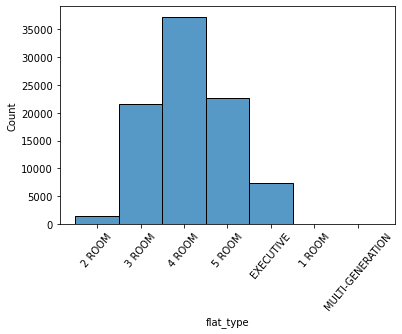

In [321]:
sns.histplot(data=df, x='flat_type')
plt.xticks(rotation=50)
plt.show()

#### Remove 'flat_type' (2 room, 1 room, Multi-Generation) as not much transactions for these flat type.

In [322]:
df = df[(df.flat_type!='1 ROOM') & (df.flat_type!='2 ROOM') & (df.flat_type!='MULTI-GENERATION')]

df.flat_type.unique()                # check if removed successfully

array(['3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE'], dtype=object)

#### Remove data for Jan 2021 as only 1 month of information.

In [323]:
df_2021 = df.loc['2021']           # keep a copy for further comparision

In [324]:
# drop data for Jan 2021
df = df[df.index != '2021']
df.tail(2)                         #check if dropped sucessfully

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
registration_date,,,,,,,,,,
2020-12-01,YISHUN,EXECUTIVE,834,YISHUN ST 81,10 TO 12,146.0,Maisonette,1988,66.17,683500.0
2020-12-01,YISHUN,EXECUTIVE,824,YISHUN ST 81,07 TO 09,142.0,Apartment,1987,65.92,670000.0


In [325]:
df.shape               # final data size

(86201, 10)

### Relationship between price and other variables

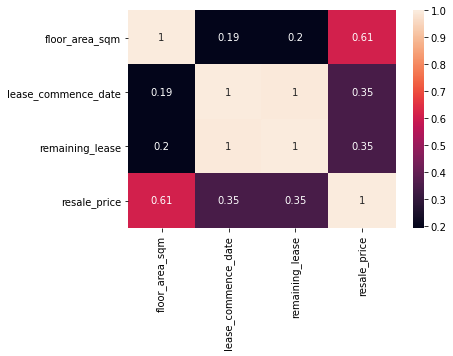

In [326]:
sns.heatmap(df.corr(), annot=True)

plt.show()

#### There is a positive relationship between those numerical variables and the resale price. What about those categorical variables?

#### Town vs resale price:

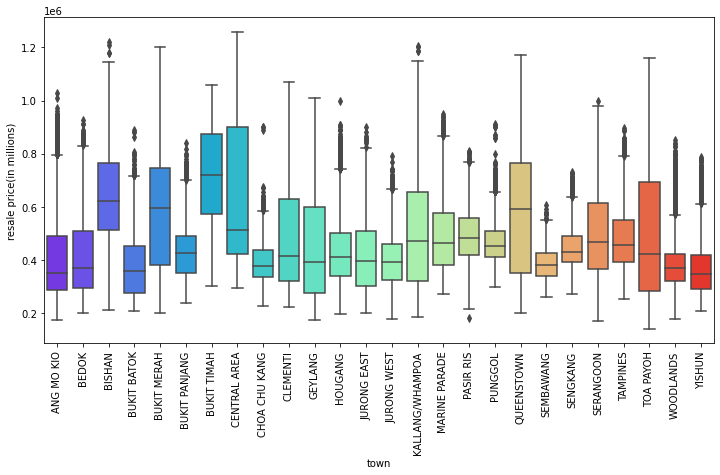

In [327]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='town', y='resale_price', data=df, palette='rainbow')
plt.xticks(rotation=90)
plt.ylabel('resale price(in millions)')
plt.show()

#### The median price varies across the town and there are a lot of outlier in some town. This might because of the different flat type, flat model, location.

#### Flat type vs resale price

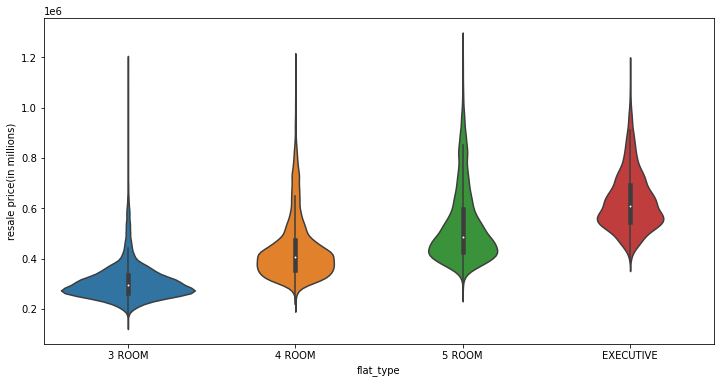

In [328]:
plt.figure(figsize=(12,6))
sns.violinplot(x=df.flat_type, y=df.resale_price, data=df)
plt.ylabel('resale price(in millions)')

plt.show()

#### There is a positive relationship between flat type and resale price. Most of the price for each flat type are around the median price. The outlier might because of flat model, location within the town.

#### Storey range vs resale price:

In [329]:
storey_range = df.groupby('storey_range')[['resale_price']].median()

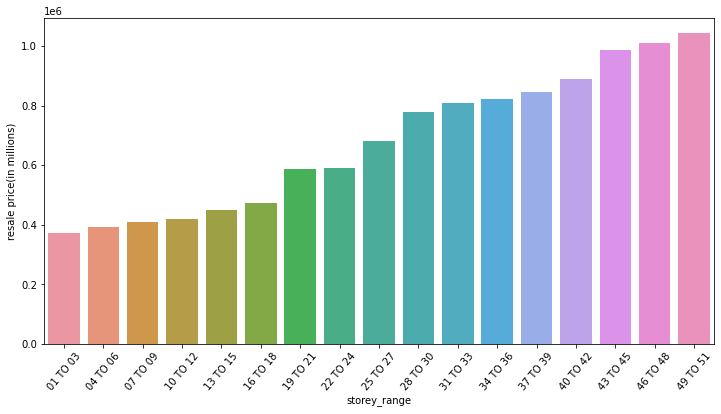

In [330]:
plt.figure(figsize=(12,6))
sns.barplot(x=storey_range.index, y='resale_price', data=storey_range)
plt.xticks(rotation=50)
plt.ylabel('resale price(in millions)')

plt.show()

#### There is a strong positive relationship between storey range and resale price. This might because of the view from the flat. 

#### Flat Model vs resale price:

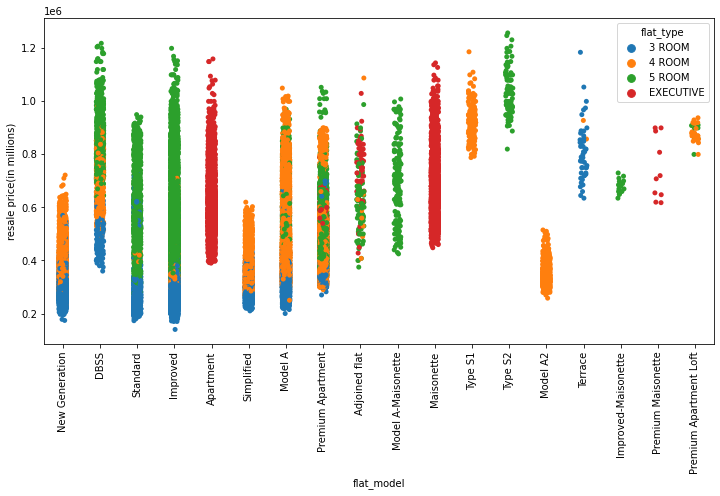

In [331]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
sns.stripplot(x='flat_model', y='resale_price', hue='flat_type', data=df)
plt.ylabel('resale price(in millions)')

plt.show()

#### The resale price varies between different flat model. This might because differant flat model has different the floor area. 

#### So it seems like almost all variables have an impact on the resale pricing.

### How location can affect the resale price:

### Distance to downtown - Shenton Way (Raffles MRT station) vs price:

In [332]:
# load and read the data we create manually on the estimated time from each town to shenton way(Raffles MRT)
travel_time = pd.read_excel('travel time.xlsx')

In [333]:
travel_time.head(2)

,town,time_min
0,ANG MO KIO,17
1,BEDOK,18


In [334]:
# groupby 'town' with 'resale_price'
town = df.groupby('town')[['resale_price']].median()

In [335]:
town.head(2)

,resale_price
town,
ANG MO KIO,350000.0
BEDOK,368000.0


In [336]:
# merge town with travel_time
town = pd.merge(town, travel_time, how='left', left_on=['town'], right_on=['town']) 

In [337]:
town.head(2)

,town,resale_price,time_min
0,ANG MO KIO,350000.0,17
1,BEDOK,368000.0,18


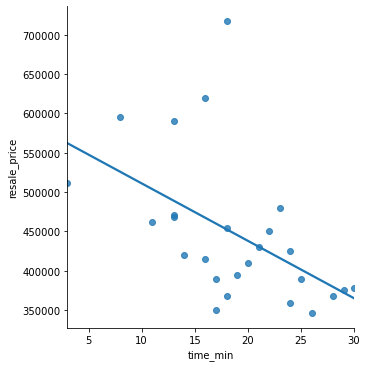

In [338]:
sns.lmplot(x='time_min', y='resale_price', data=town, ci=0)
plt.show()

#### As shown from the graph, the median resale price is affected because of the distance to downtown. The further away, the cheaper it is. But what is the difference like?
#### Let's take a 4 room flat in Woodlands and Bishan for example and see what is the price difference.

In [339]:
# get the data for 4 room flat in Woodlands and Bishan
woodlands = df[(df.town=='WOODLANDS')&(df.flat_type=='4 ROOM')]
bishan = df[(df.town=='BISHAN')&(df.flat_type=='4 ROOM')]

In [340]:
# get the difference between the cheapest flat in bishan and woodlands
print('The price difference is: $'+str(bishan.resale_price.min()-woodlands.resale_price.min()))

The price difference is: $110000.0


### Is there any exception?

In [341]:
# get min price of each town
min_price = df.groupby('town')['resale_price'].agg(['min'])

In [342]:
min_price.head(2)

,min
town,
ANG MO KIO,174000.0
BEDOK,200000.0


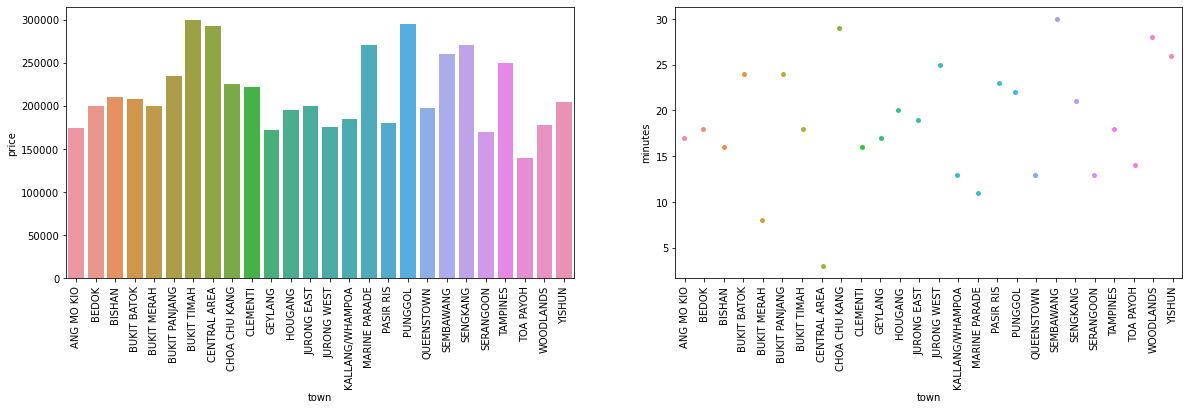

In [343]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
sns.barplot(x=min_price.index, y=min_price['min'], data=min_price, ax=axes[0])
sns.stripplot(x=town.town, y=town.time_min, data=town, ax=axes[1])

for label in axes[0].get_xticklabels():
    label.set_rotation(90)

for label in axes[1].get_xticklabels():
    label.set_rotation(90)

axes[0].set_xlabel('town')
axes[0].set_ylabel('price')
axes[1].set_xlabel('town')
axes[1].set_ylabel('minutes')

plt.show()

#### YES!!! The minimum resale price for Central Area (which should be the nearest to downtown) is slightly less then $300,000. 
#### Let's get the detail.

In [344]:
# get the data of min price for central area
central_area = df.loc[df.town=='CENTRAL AREA']

In [345]:
central_area.loc[central_area.resale_price==central_area.resale_price.min()]

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
registration_date,,,,,,,,,,
2020-06-01,CENTRAL AREA,3 ROOM,29,KELANTAN RD,04 TO 06,65.0,Improved,1977,56.5,292000.0


#### For those who wants convenience with a low budget might want to consider the flats around Kelantan Road.

#### Now we know that the location of the town has an impact on the resale pricing, what about the location within the town that are nearer to MRT station?

### Distance to nearest MRT station vs price:

In [346]:
# load and read the data we created using Onemap.sg
geolocation = pd.read_csv('geolocation.csv')

In [347]:
geolocation.head(2)

,Unnamed: 0,address,latitude,longtitude
0,0,406 ANG MO KIO AVE 10,1.362005,103.853880
1,1,108 ANG MO KIO AVE 4,1.370943,103.837975


In [348]:
# drop col. 'Unnamed: 0'
geolocation.drop('Unnamed: 0', axis=1, inplace=True)

In [349]:
geolocation.head(2)

,address,latitude,longtitude
0,406 ANG MO KIO AVE 10,1.362005,103.853880
1,108 ANG MO KIO AVE 4,1.370943,103.837975


In [350]:
mrt_station = pd.read_csv('mrt_station.csv')

In [351]:
mrt_station.head(2)

,Unnamed: 0,mrt_station,latitude,longtitude
0,0,Jurong East MRT Station,1.333577,103.742292
1,1,Bukit Batok MRT Station,1.348424,103.749126


In [352]:
mrt_station.drop('Unnamed: 0', axis=1, inplace=True)

In [353]:
mrt_station.head(2)

,mrt_station,latitude,longtitude
0,Jurong East MRT Station,1.333577,103.742292
1,Bukit Batok MRT Station,1.348424,103.749126


In [354]:
# find the distance from address to mrt station
start_lat = geolocation.latitude
start_long = geolocation.longtitude

In [355]:
end_lat = mrt_station.latitude
end_long = mrt_station.longtitude

In [356]:
# group latitude and longitude for start and end address
start_address = []
for lat, long in zip(start_lat, start_long):
    start_address.append((lat, long))

In [357]:
end_address = []
for lat, long in zip(end_lat, end_long):
    end_address.append((lat, long))

In [358]:
# get distance for individual address in km
min_distance = []
temp = []
for start_pt in start_address:
    for end_pt in end_address:
        temp.append(round(geodesic(start_pt, end_pt).km, 2))
    min_distance.append(min(temp))
    temp.clear()

In [359]:
# create a new coloumn 'min_distance' for geolocation dataframe
geolocation['min_distance'] = min_distance

In [360]:
geolocation.head(2)

,address,latitude,longtitude,min_distance
0,406 ANG MO KIO AVE 10,1.362005,103.853880,0.98
1,108 ANG MO KIO AVE 4,1.370943,103.837975,1.32


In [361]:
#create new coloumn 'address' for df dataframe for merging
df['address'] = df.block + ' ' + df.street_name 

In [362]:
df.head(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address
registration_date,,,,,,,,,,,
2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0,108 ANG MO KIO AVE 4
2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,262000.0,602 ANG MO KIO AVE 5


In [363]:
# reset index for merging
df.reset_index(inplace=True)

In [364]:
# merge geolocation with df
df = pd.merge(df, geolocation, how='left', left_on=['address'], right_on=['address'], left_index=True)

In [365]:
# set back the index
df.set_index('registration_date', inplace=True)

In [366]:
df.head(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,latitude,longtitude,min_distance
registration_date,,,,,,,,,,,,,,
2017-01-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60.58,250000.0,108 ANG MO KIO AVE 4,1.370943,103.837975,1.32
2017-01-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62.42,262000.0,602 ANG MO KIO AVE 5,1.380709,103.835368,1.04


In [367]:
# take a look at min and max distance
print('min distance:', df.min_distance.min())
print('max distance:', df.min_distance.max())

min distance: 0.02
max distance: 11536.35


In [368]:
# there is an error for the max distance
# Check the data
df[df.min_distance==df.min_distance.max()].head(2)

,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,address,latitude,longtitude,min_distance
registration_date,,,,,,,,,,,,,,
2017-01-01,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,13 TO 15,59.0,Improved,1976,58.33,286000.0,3 ST. GEORGE'S RD,0.0,0.0,11536.35
2017-01-01,KALLANG/WHAMPOA,3 ROOM,3,ST. GEORGE'S RD,07 TO 09,59.0,Improved,1976,58.33,320000.0,3 ST. GEORGE'S RD,0.0,0.0,11536.35


In [369]:
# seem like we can't get the geolocation for certain area from Onemap.sg
error = df[df.min_distance==df.min_distance.max()]   # get all error data
error.shape

(190, 14)

In [370]:
# check which area
error.town.unique()

array(['KALLANG/WHAMPOA'], dtype=object)

In [371]:
# cleaning the data
error = list(df[df.town=='KALLANG/WHAMPOA'].min_distance)  # get all distance for kallang/whampoa 
                                                           # since all error is in that area

In [372]:
# set the error distance to 0
for i in range(len(error)):
    if error[i]==max(error):
        error[i] = 0
    else:
        error[i] = error[i]

In [373]:
# get the average distance to repalce the error distance
avg = round(sum(error)/len(error),2)

In [374]:
# before cleaning
df[df.town=='KALLANG/WHAMPOA'].min_distance.head()

registration_date
2017-01-01        0.79
2017-01-01        1.03
2017-01-01    11536.35
2017-01-01        0.27
2017-01-01    11536.35
Name: min_distance, dtype: float64

In [375]:
# replace the average to df dataframe
df.replace(df.min_distance.max(), avg, inplace=True)

In [376]:
# after cleaning
df[df.town=='KALLANG/WHAMPOA'].min_distance.head()

registration_date
2017-01-01    0.79
2017-01-01    1.03
2017-01-01    0.46
2017-01-01    0.27
2017-01-01    0.46
Name: min_distance, dtype: float64

In [377]:
# bin 'min_distance' for ploting
df['dist_bins'] = pd.cut(x=df.min_distance, bins=[0,0.5,1,1.5,2,2.5,3,3.5,4], 
                         labels=['0 to 0.5','0.51 to 1.0','1.1 to 1.5','1.51 to 2.0',\
                                 '2.1 to 2.5','2.51 to 3.0','3.1 to 3.5','3.51 to 4.0'])  

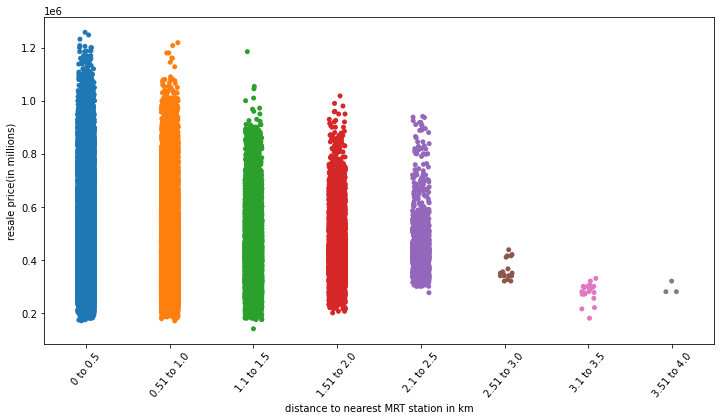

In [378]:
plt.figure(figsize=(12,6))
sns.stripplot(x='dist_bins', y='resale_price', data=df)
plt.xticks(rotation=50)
plt.xlabel('distance to nearest MRT station in km')
plt.ylabel('resale price(in millions)')

plt.show()

#### As we can see from the graph, the price is also affected by the distance to MRT station. Again, let's take a 4 room flat in Woodlands for example and see how much can the difference be.

In [379]:
# get the data of 4 room flats in Woodlands from the new data
woodlands = df[(df.town=='WOODLANDS')&(df.flat_type=='4 ROOM')]

In [380]:
# get nearest and furthest data
nearest = woodlands[woodlands.min_distance==woodlands.min_distance.min()]
furthest = woodlands[woodlands.min_distance==woodlands.min_distance.max()]

In [381]:
print('The price diffence is: $'+str(nearest.resale_price.max()-furthest.resale_price.max()))

The price diffence is: $37000.0


#### We can safely say that convenience has a strong positive correlationship with resale pricing.

### Which town has the most transaction and why?

In [382]:
# get the number of transaction for each town by year
transaction_by_town = pd.crosstab(index=df.index.year, columns=df.town)

In [383]:
transaction_by_town.head(2)

town,ANG MO KIO,BEDOK,BISHAN,BUKIT BATOK,BUKIT MERAH,BUKIT PANJANG,BUKIT TIMAH,CENTRAL AREA,CHOA CHU KANG,CLEMENTI,...,PASIR RIS,PUNGGOL,QUEENSTOWN,SEMBAWANG,SENGKANG,SERANGOON,TAMPINES,TOA PAYOH,WOODLANDS,YISHUN
row_0,,,,,,,,,,,,,,,,,,,,,
2017,919,1139,445,736,798,694,57,177,801,437,...,626,1305,511,523,1504,430,1296,721,1530,1243
2018,1000,1117,405,841,831,745,61,172,928,477,...,625,1510,605,582,1601,456,1349,714,1660,1269


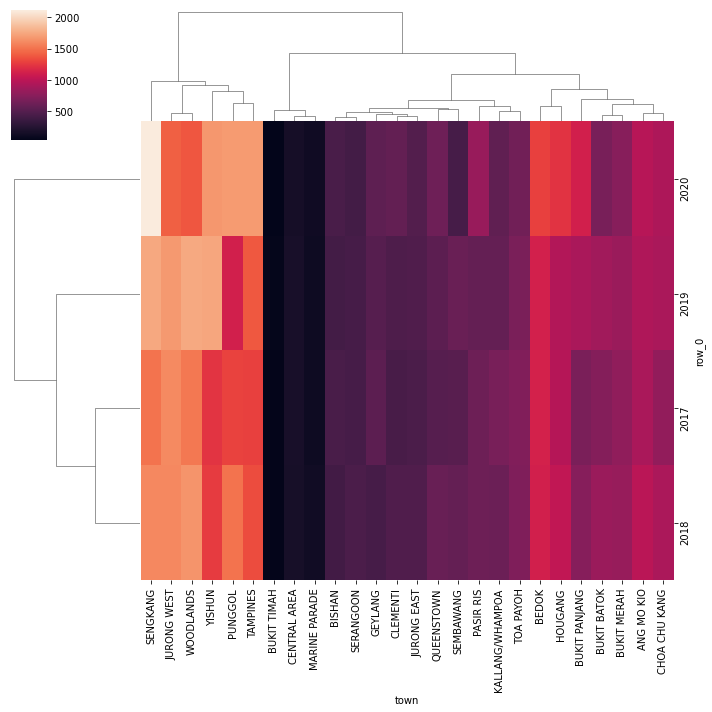

In [384]:
sns.clustermap(transaction_by_town).savefig('town.png')

plt.show()

#### We can see that  the transaction of the top 6 town (Sengkang, Jurong West, Woodlands, Yishun, Punggol and Tampines) have increase the most compared to other town across the years. Why is this so?

### Is remaining lease a factor?

In [385]:
# group 'town' with 'resale_price' and 'remainig _lease' and sort by 'remainig_lease'
avg_lease_remain_price = df.groupby('town')['resale_price', 'remaining_lease'].median()\
                        .sort_values(by='remaining_lease', ascending=False)

<ipython-input-385-a782f15eecbf>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_lease_remain_price = df.groupby('town')['resale_price', 'remaining_lease'].median()\


In [386]:
avg_lease_remain_price.head()

,resale_price,remaining_lease
town,,
PUNGGOL,450000.0,93.50
SENGKANG,430000.0,86.67
SEMBAWANG,378000.0,82.00
BUKIT PANJANG,425000.0,80.83
WOODLANDS,368000.0,78.00


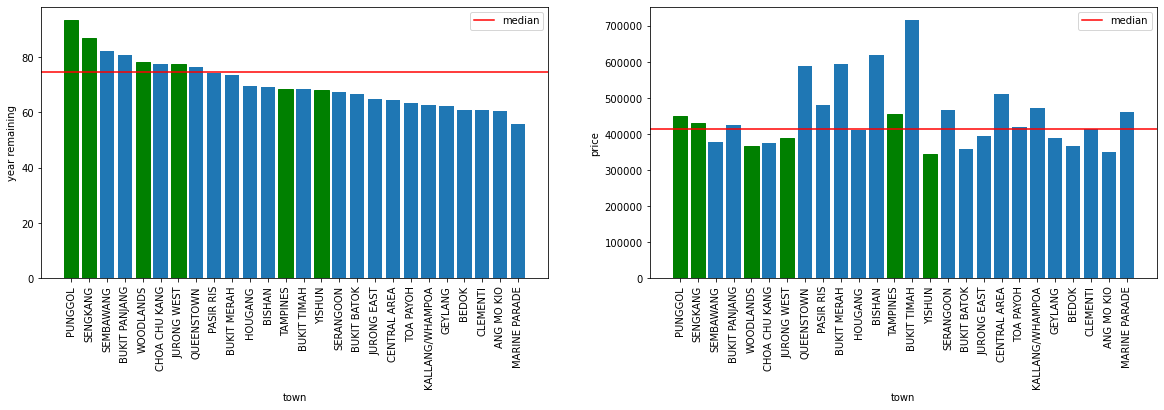

In [387]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

# save axes to variable 'barlist'
barlist_0 = axes[0].bar(avg_lease_remain_price.index, avg_lease_remain_price.remaining_lease)
barlist_1 = axes[1].bar(avg_lease_remain_price.index, avg_lease_remain_price.resale_price)

for label in axes[0].get_xticklabels():
    label.set_rotation(90)

for label in axes[1].get_xticklabels():
    label.set_rotation(90)

axes[0].set_xlabel('town')
axes[0].set_ylabel('year remaining')
axes[1].set_xlabel('town')
axes[1].set_ylabel('price')
axes[0].axhline(y=df.remaining_lease.mean(), color='r', linestyle='-', label='median')
axes[1].axhline(y=df.resale_price.median(), color='r', linestyle='-', label='median')
axes[0].legend()
axes[1].legend()

# create a list of bar we want to change color
bar = [1,6,4,12,14,0]               
[barlist_0[i].set_color('g') for i in bar]       # set the color of the bar we want
[barlist_1[i].set_color('g') for i in bar]
    
plt.savefig('remain.png')

#### From the left chart, the remaining lease sure is a factor as 4 of the top 6 town have a remaining lease of more than 75 years (which is the median remaining lease). Also, price is another factor. As shown in the right chart, the price of the top 6 towns is in the region of the median price. Other possible factor could be these towns are still developing. With more planning for these towns, it is sensible to get a flat in these town as the flat are newer and reasonably priced.

### What is the trend like for the past years?

In [388]:
# get the median resale price by month of each year
yearly_trend = df.pivot_table(values='resale_price', index=df.index.month, columns=df.index.year, aggfunc=np.median)

In [389]:
yearly_trend.head(2)

registration_date,2017,2018,2019,2020
registration_date,,,,
1,406000.0,418000.0,398000.0,405000.0
2,415000.0,410000.0,396500.0,410000.0


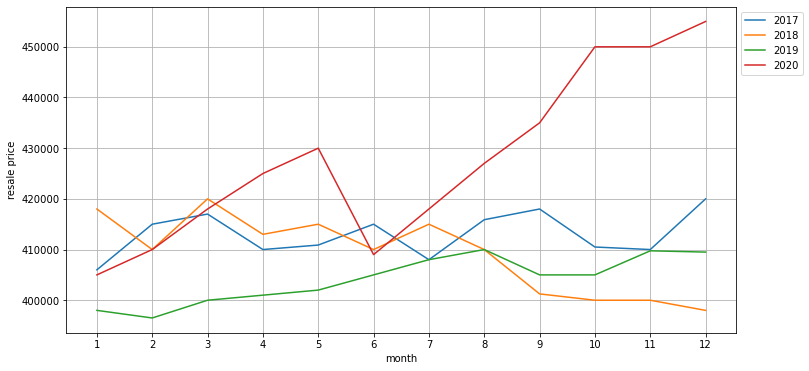

In [390]:
yearly_trend.plot(figsize=(12,6), xlabel='month', ylabel='resale price', xticks=yearly_trend.index, grid=True)
plt.legend(bbox_to_anchor=(1,1))

plt.savefig('trend.png')

In [391]:
# find the increase in percentage from Jun 2020 to Dec 2020
jun = yearly_trend.loc[6, 2020]
dec = yearly_trend.loc[12, 2020]

In [392]:
print('The percentage change in price between Jun to Dec, 2020: '+str(round((dec-jun)/jun*100, 2))+'%')

The percentage change in price between Jun to Dec, 2020: 11.25%


#### The resale price is quite stable throughout until end 2019. Since the start of 2020, the price is picking up constantly. Although there is a drop from May which is during the circuit breaker, the market has bound back from Jun onwards after the end of the circuit breaker. Like we have calculated, it has increase by 11.25%!!!

### How is the trend like coming to 2021?

In [393]:
# we have keep a copy of Jan 2021 data earlier
# groupby index and 'resale_price'
df_2021 = df_2021.groupby(df_2021.index)[['resale_price']].median()

In [394]:
df_2021.head()

,resale_price
registration_date,
2021-01-01,460000.0


In [395]:
# get data for 2020
df_2020 = df['2020']

In [396]:
# groupby index and 'resale_price'
df_2020 = df_2020.groupby(df_2020.index)[['resale_price']].median()

In [397]:
df_2020.head(2)

,resale_price
registration_date,
2020-01-01,405000.0
2020-02-01,410000.0


In [398]:
# join df_2020 and df_2021
jan20_to_2021 = pd.concat([df_2020, df_2021])

In [399]:
jan20_to_2021.tail(2)

,resale_price
registration_date,
2020-12-01,455000.0
2021-01-01,460000.0


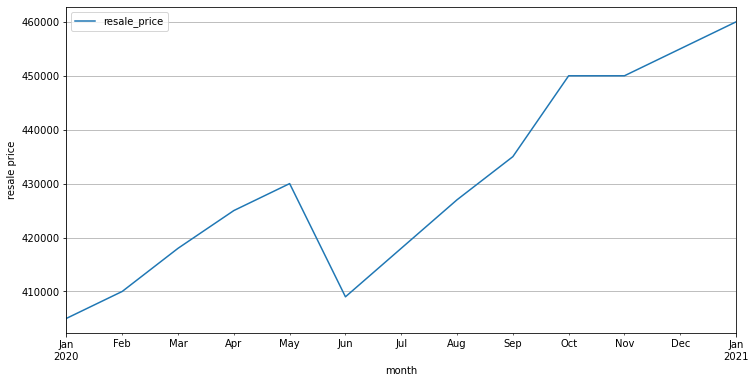

In [400]:
jan20_to_2021.plot(kind='line', xlabel='month', ylabel='resale price', figsize=(12,6),
                   grid=True)

plt.show()

#### Seem like the price is still going north as it has already increase about $5,000 in Jan 2021.

### Conclusion:
#### The price increase from the start of last year might be due to the current pandemic. The T.O.P of most BTO flat has been delayed due to the pandemic, causing buyer to look at the resale market since the government has enhance some policy like more CPF housing grant, thus causing the price to increase. Unless there is another round of cooling measure introduced, the resale price will likely to continue in the northerly direction.